# RITAL - Bag of Words Project

Binôme :
- **Ben KABONGO**, 21116436

- **Sofia BORCHANI**, 21212080

## Partie I : Données reconnaissance du locuteur (Chirac/Mitterrand) : prise en main des données et extraction de vocabulaire

Dans cette section, nous allons prendre en main les données, tester les différents prétraitements sur les données et étudier le vocabulaire.

### Problématiques

#### Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).


#### Extraction du vocabulaire

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

import utils # utilitaires et fonctions de préprocessing

In [2]:
plt.style.use('seaborn-whitegrid')

## Prise en main des données

### Chargement des données

In [3]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
all_locuteur_df = utils.load_pres(fname)
all_locuteur_df

,text,label
0,"Quand je dis chers amis, il ne s'agit pas là ...",1
1,D'abord merci de cet exceptionnel accueil que...,1
2,C'est toujours très émouvant de venir en Afri...,1
3,Aucun citoyen français ne peut être indiffére...,1
4,"Le Congo, que naguère le <nom> qualifia de ""r...",1
...,...,...
57408,Je suis heureux de le mener avec vous.\n,1
57409,"Vous le savez, comme vous, j'ai la passion de...",1
57410,Je crois en son avenir.\n,1
57411,"Je crois en la politique, c'est-à-dire en not...",1


### Distribution des classes

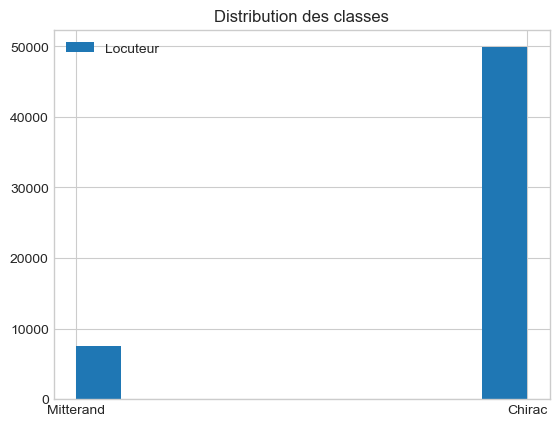

In [4]:
all_locuteur_df['label'].hist()
plt.title('Distribution des classes')
plt.xticks([-1, +1], ['Mitterand', 'Chirac'])
plt.legend(labels=['Locuteur'])
plt.show()

`Classes non équilibrées : beaucoup d'exemples de la classe 1 et peu de la classe -1.`

### Longueur des documents

#### Longueur de tous les documents

In [5]:
all_locuteur_df['length'] = all_locuteur_df.text.map(len)
all_locuteur_df.head()

,text,label,length
0,"Quand je dis chers amis, il ne s'agit pas là ...",1,117
1,D'abord merci de cet exceptionnel accueil que...,1,113
2,C'est toujours très émouvant de venir en Afri...,1,304
3,Aucun citoyen français ne peut être indiffére...,1,76
4,"Le Congo, que naguère le <nom> qualifia de ""r...",1,187


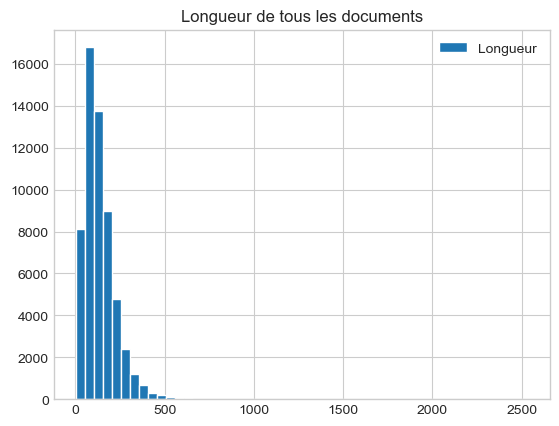

In [6]:
all_locuteur_df['length'].sort_values().hist(bins=50, edgecolor='white')
plt.title('Longueur de tous les documents')
plt.legend(labels=['Longueur'])
plt.show()

#### Longueur de tous les documents par classes

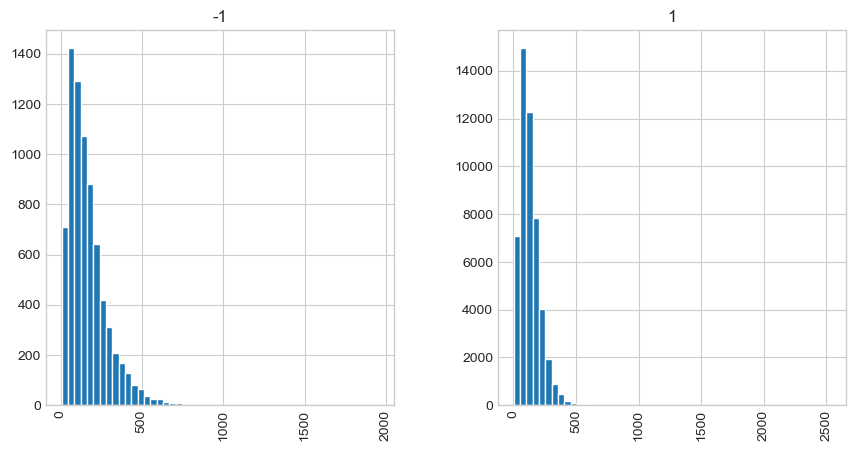

In [7]:
all_locuteur_df['length'].hist(bins=50, edgecolor='white', by=all_locuteur_df['label'], figsize=(10, 5))
plt.show()

In [8]:
all_locuteur_df.groupby('label').describe()

length                                                         
         count        mean         std  min   25%    50%    75%     max
label                                                                  
-1      7523.0  164.231822  120.202628  7.0  78.0  135.0  217.5  1951.0
 1     49890.0  132.248968   82.298427  4.0  73.0  116.0  173.0  2530.0

#### Document le plus long et le plus court

In [9]:
# document le plus long
all_locuteur_df[all_locuteur_df['length'] == 2530]['text'].iloc[0]

" orienterons l'aide bilatérale en priorité vers les pays qui témoignent de leur engagement à améliorer leurs performances en matière de transparence, de bonne gouvernance et de respect de l'état de droit ; demanderons des évaluations de la qualité de la gestion des finances publiques avant que les pays puissent bénéficier d'un soutien budgétaire (comme cela se pratique déjà dans le cadre des crédits de soutien à la réduction de la pauvreté accordés par la Banque mondiale), veillerons à ce que les résultats de ces évaluations et de celles de la gouvernance des pays soient systématiquement rendus publics et améliorerons la coordination et l'harmonisation de nos procédures administratives ; encouragerons tous les pays en développement à élaborer, dans le cadre de leurs stratégies de réduction de la pauvreté, des plans d'action concrets pour la gestion des finances publiques et la responsabilité fixant des objectifs mesurables et liés à des échéances précises, et invitons le FMI et la Ban

In [10]:
# document le plus court
all_locuteur_df[all_locuteur_df['length'] == 4]['text'].iloc[0]

' * \n'

## Prétraitements

### Suppression de ponctuation

In [11]:
doc = all_locuteur_df.text[0]
print(doc)
print()
print(utils.delete_punctuation(doc))

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.


 Quand je dis chers amis il ne s agit pas là d une formule diplomatique mais de l expression de ce que je ressens 


### Suppression de chiffres

In [12]:
doc = all_locuteur_df.text[1334]
print(doc)
print()
print(utils.delete_digit(doc))

 100000 chômeurs de plus, c'est 4 milliards de moins pour la Sécurité sociale, indépendamment du coût pour le système économique dans son ensemble.


  chômeurs de plus, c'est  milliards de moins pour la Sécurité sociale, indépendamment du coût pour le système économique dans son ensemble.



### Transformation des mots entièrement en majuscule en marqueurs spécifiques

In [13]:
doc = all_locuteur_df.text[2467]
print(doc)
print()
print(utils.replace_maj_word(doc))

 Les études de l'OMS et de l'ONUSIDA le démontrent : l'épidémie s'étend, en Asie, en Russie, dans les pays de la CEI, dans les pays d'Europe centrale et orientale.


Les études de l <MAJ> et de l <MAJ> le démontrent l épidémie s étend en Asie en Russie dans les pays de la <MAJ> dans les pays d Europe centrale et orientale


### Suppression des balises

In [14]:
doc = all_locuteur_df.text[295]
print(doc)
print()
print(utils.delete_balise(doc))

 D'un chef d'Etat, le <nom> , dont je salue le courage et la détermination.


 D'un chef d'Etat, le  , dont je salue le courage et la détermination.



### Première ligne

In [15]:
doc = all_locuteur_df.text[162]
print(doc)
print()
print(utils.first_line(doc))

 Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture... des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne.


 Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture


### Dernière ligne

In [16]:
doc = all_locuteur_df.text[162]
print(doc)
print()
print(utils.last_line(doc))

 Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture... des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne.


 des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne


### Stemming

In [17]:
doc = all_locuteur_df.text[162]
print(doc)
print()
print(utils.stem(doc))

 Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture... des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne.


il suff de se retourn de ce côté-là pour apercevoir de profil saint-flour qui n'est pas une vill néglige par son architectur ... de château , de ferm , le parcellair de terr , témoin de tant de travail et de tant de réussit accumul à traver le siecl au point d'avoir cré une form d'esthet , la beaut de la franc , à laquel prend part , évident , la beaut de l'auvergn .


## Extraction du vocabulaire

### Exploration préliminaire du jeu de données

#### Taille de vocabulaire initial

In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_locuteur_df.text)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))

Taille initiale du vocabulaire : 28524


#### WordCloud : mots du vocabulaire initial

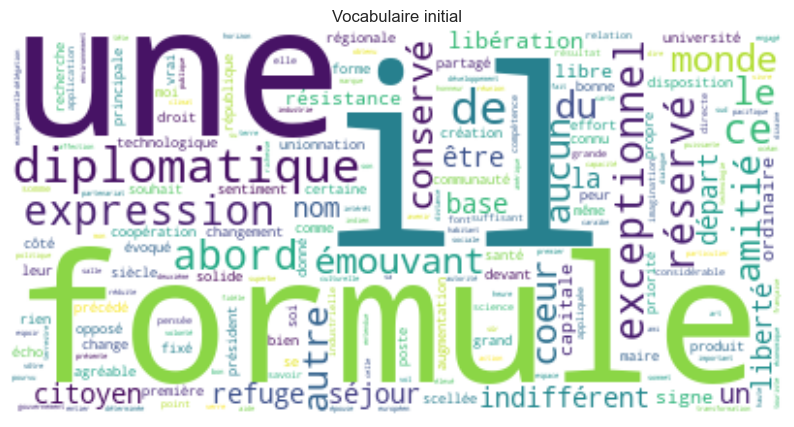

In [19]:
wc = WordCloud(background_color='white').generate(' '.join(vectorizer.vocabulary_.keys()))
plt.figure(figsize=(10, 8))
plt.title('Vocabulaire initial')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud : mots les plus fréquents - avec les stop words

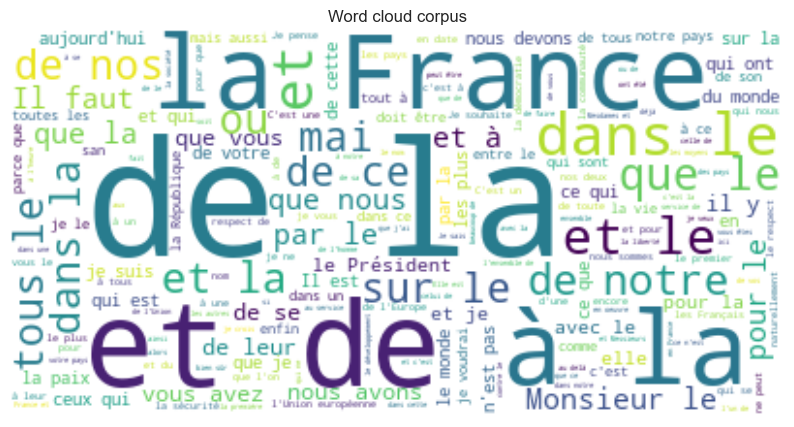

In [20]:
wc = WordCloud(background_color='white').generate(' '.join(all_locuteur_df.text))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud : 100 mots les plus fréquents - avec les stop words

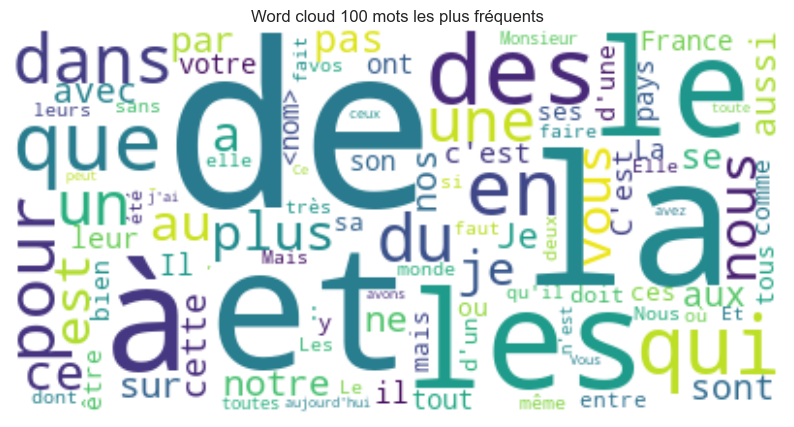

In [21]:
words = " ".join(all_locuteur_df.text).split()
word_counter = Counter(words)

top_100_words = dict(word_counter.most_common(100))

wc = WordCloud(background_color='white').generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 mots les plus fréquents')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
tmp_df = pd.DataFrame()
top_100_words = list(top_100_words)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = top_100_words[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,de,pour,ce,se,C'est,tous,doit,qu'il,dont,n'est
1,la,dans,a,sont,France,ou,y,Le,deux,aujourd'hui
2,et,du,je,Je,ont,:,d'un,Nous,Elle,Vous
3,à,un,pas,aux,tout,être,entre,si,vos,ceux
4,les,une,par,cette,votre,comme,faire,leurs,monde,peut
5,le,nous,notre,aussi,son,mais,même,fait,elle,avez
6,des,plus,ne,c'est,pays,ces,Et,Mais,toutes,Ce
7,que,au,sur,il,La,sa,sans,où,",",avons
8,qui,est,nos,leur,<nom>,d'une,été,Les,Monsieur,toute
9,en,vous,avec,Il,ses,bien,faut,très,-,j'ai


#### Word cloud : odds ratio - avec les stop words

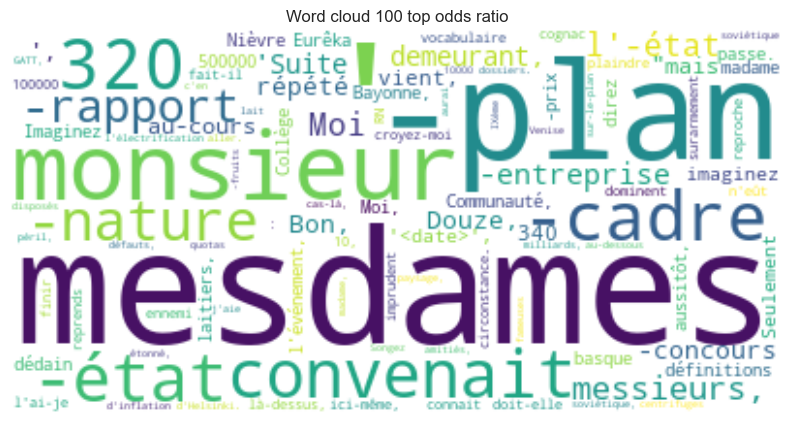

In [23]:
class1_words = ' '.join(all_locuteur_df[all_locuteur_df['label'] == -1].text).split()
class2_words = ' '.join(all_locuteur_df[all_locuteur_df['label'] == +1].text).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud(background_color='white').generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Loi de Zipf

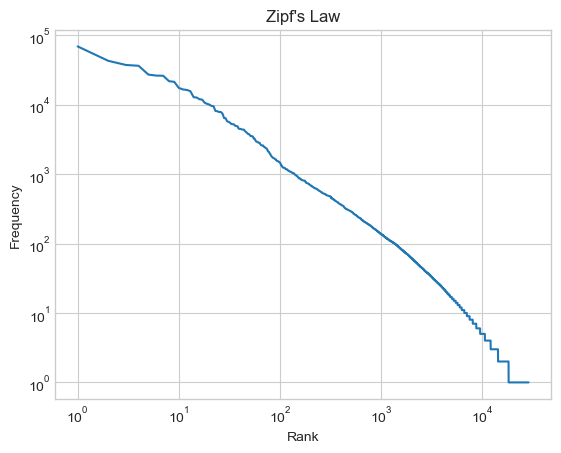

In [24]:
corpus_clean = ' '.join(all_locuteur_df.text.map(utils.delete_punctuation)).lower()
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
word_freqs = [word_counts[w] for w in sorted_words]
ranks = range(1, len(sorted_words) + 1)

plt.title('Zipf\'s Law')
plt.plot(ranks, word_freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()


#### Bigrammes les plus fréquents

In [25]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(all_locuteur_df.text)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()
sorted_features = [features[i] for i in bigram_frequencies_sorted[:100]]

In [26]:
tmp_df = pd.DataFrame()
bigrams = sorted_features
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,de la,tous les,il est,ce qui,du monde,je suis,de ces,la république,est aussi,de plus
1,et de,dans la,et des,ceux qui,de cette,est la,par le,union européenne,par les,pour que
2,la france,et les,qui est,que je,le monde,les plus,mais aussi,je le,pour le,les pays
3,aujourd hui,que nous,que les,sur le,qu elle,la paix,je voudrais,parce que,la sécurité,dans ce
4,dans le,vous avez,et le,ce que,sur la,notre pays,de son,plus de,entre les,je pense
5,et la,monsieur le,le président,qui ont,par la,qu ils,sur les,dans un,de europe,et en
6,qu il,que la,et je,est un,que le,toutes les,de leur,les français,je souhaite,nos deux
7,de notre,dans les,pour la,de ce,est une,est le,de tous,en date,avec les,la démocratie
8,de nos,nous avons,est pas,nous devons,pour les,la vie,elle est,je vous,que on,et du
9,il faut,que vous,et qui,de votre,de ses,doit être,qui sont,qui se,nous sommes,avec le


#### Trigrammes les plus fréquents

In [27]:
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(all_locuteur_df.text)

trigram_frequencies = np.array(X.sum(axis=0))[0]
trigram_frequencies_sorted = (-trigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()
sorted_features = [features[i] for i in trigram_frequencies_sorted[:100]]

In [28]:
tmp_df = pd.DataFrame()
bigrams = sorted_features
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,de la france,ce est pas,de la paix,tous ceux qui,je sais que,de ceux qui,le premier ministre,dans le respect,le respect des,je crois que
1,monsieur le président,de la vie,que nous avons,sur le plan,le respect de,des droits de,plus que jamais,et messieurs les,il est pas,de la liberté
2,et de la,de plus en,de notre pays,la lutte contre,ceux qui ont,au coeur de,tous les français,ce qu il,de votre pays,il pas de
3,dans le monde,plus en plus,je suis heureux,de la démocratie,les moyens de,de la société,un certain nombre,le cadre de,je me réjouis,la france qui
4,de la république,de tous les,de union européenne,vous le savez,au nom de,qu il agisse,de la sécurité,que nous devons,ne peut pas,la qualité de
5,mesdames et messieurs,nos deux pays,ce qui est,président de la,de la nation,dans ce domaine,la communauté internationale,la paix et,pour la france,de ce que
6,la france est,dans le domaine,droits de homme,au sein de,en même temps,des nations unies,on ne peut,au cours des,de nos concitoyens,parce qu il
7,et la france,la france et,la mise en,entre nos deux,au delà de,qu il est,de toutes les,en matière de,tout ce qui,au moment où
8,que la france,au service de,monsieur le maire,ne sont pas,qu il faut,mise en oeuvre,suis heureux de,au cours de,de la solidarité,il nous faut
9,que vous avez,dans le cadre,je souhaite que,de la communauté,est aujourd hui,le président de,il faut que,dans tous les,au delà des,dans notre pays


### Stops words

#### Liste des stop words français

In [29]:
tmp_sw = stopwords.words('french') + ['']*3
tmp_df = pd.DataFrame()
for i in range(1, 17):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = tmp_sw[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100,101 - 110,111 - 120,121 - 130,131 - 140,141 - 150,151 - 160
0,au,en,lui,notre,sa,tu,à,étant,serai,seraient,furent,fussiez,ai,auront,avaient,aient
1,aux,et,ma,nous,se,un,m,étante,seras,étais,sois,fussent,as,aurais,eut,eusse
2,avec,eux,mais,on,ses,une,n,étants,sera,était,soit,ayant,avons,aurait,eûmes,eusses
3,ce,il,me,ou,son,vos,s,étantes,serons,étions,soyons,ayante,avez,aurions,eûtes,eût
4,ces,ils,même,par,sur,votre,t,suis,serez,étiez,soyez,ayantes,ont,auriez,eurent,eussions
5,dans,je,mes,pas,ta,vous,y,es,seront,étaient,soient,ayants,aurai,auraient,aie,eussiez
6,de,la,moi,pour,te,c,été,est,serais,fus,fusse,eu,auras,avais,aies,eussent
7,des,le,mon,qu,tes,d,étée,sommes,serait,fut,fusses,eue,aura,avait,ait,
8,du,les,ne,que,toi,j,étées,êtes,serions,fûmes,fût,eues,aurons,avions,ayons,
9,elle,leur,nos,qui,ton,l,étés,sont,seriez,fûtes,fussions,eus,aurez,aviez,ayez,


#### Word cloud : corpus sans stop words

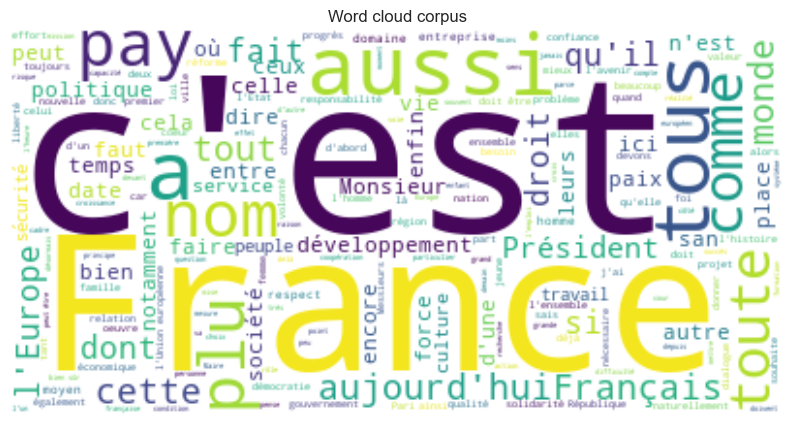

In [30]:
wc = WordCloud(background_color='white', stopwords=stopwords.words('french')).generate(' '.join(all_locuteur_df.text))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud par locuteur

In [31]:
mitter_corpus = ' '.join(all_locuteur_df[all_locuteur_df.label == -1].text)
mitter_corpus = utils.delete_punctuation(mitter_corpus).lower()

chirac_corpus = ' '.join(all_locuteur_df[all_locuteur_df.label == +1].text)
chirac_corpus = utils.delete_punctuation(chirac_corpus).lower()

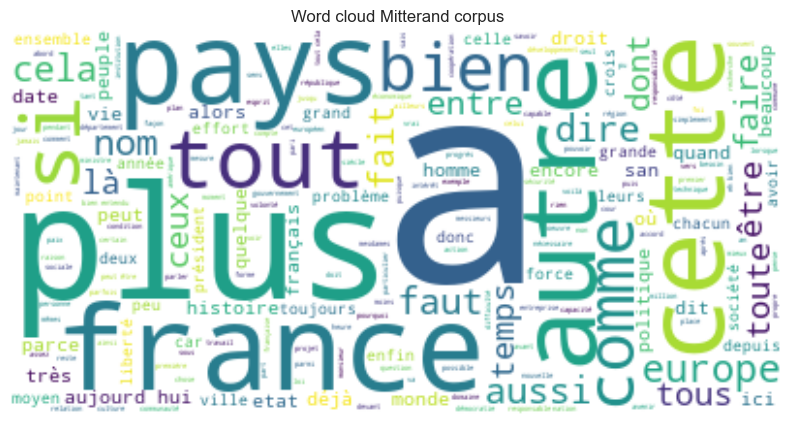

In [32]:
wc = WordCloud(background_color='white', stopwords=stopwords.words('french')).generate(mitter_corpus)
plt.figure(figsize=(10, 8))
plt.title('Word cloud Mitterand corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

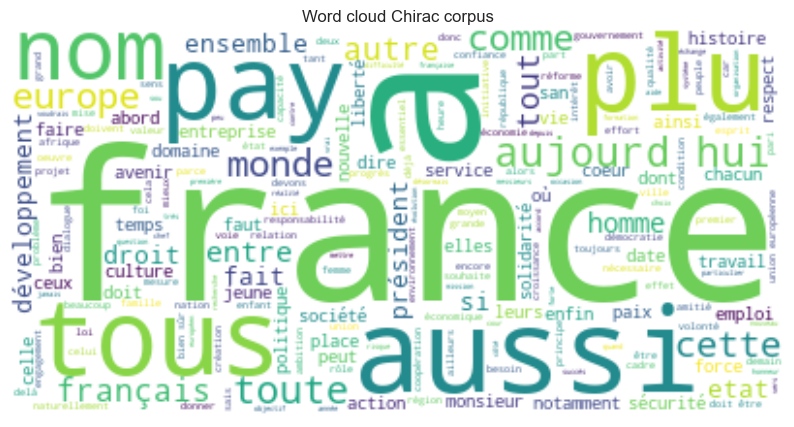

In [33]:
wc = WordCloud(background_color='white', stopwords=stopwords.words('french')).generate(chirac_corpus)
plt.figure(figsize=(10, 8))
plt.title('Word cloud Chirac corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()